# Imports and Setting up Plotting

In [157]:
from datetime import date, timedelta
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

rcParams = {'figure.max_open_warning': 0,
            'figure.figsize': (15, 8),
            'axes.grid': True}

plt.rcParams.update(rcParams)
plt.style.use('bmh')

pd.options.display.max_rows = 50

# Loading Data

In [158]:
# Reading CSV files and Loading the data
# filepath = r'c:\src\interview_project_data\*.csv' # change to my own file path
filepath = './*.csv'
csv_files = glob.glob(filepath)

data = {}

for csv_file in csv_files:
    print('Loading ', csv_file)
#     data_key = csv_file.rsplit('\\', 1)[-1].split('.')[0]    # change to mac separator
    data_key = csv_file.rsplit('/', 1)[-1].split('.')[0]    # change to mac separator

    df = pd.read_csv(csv_file)
    df.set_index('dates', inplace=True)
    df.index = pd.to_datetime(df.index)
    data[data_key] = df
    
asset_prices = data['asset_prices']

# Firstly Grab the data by country
countries = ['US', 'CA']
data_labels = ['Unemployment', 'IndustrialProduction', 'GDP', 'HomeSales']

economic_data = {}

for country in countries:
    tmp_data = {}

    for label in data_labels:
        tmp_data[f'{label}'] = data[f'{country}_{label}']

    economic_data[f'{country}'] = tmp_data

Loading  ./CA_Unemployment.csv
Loading  ./CA_IndustrialProduction.csv
Loading  ./US_Unemployment.csv
Loading  ./US_HomeSales.csv
Loading  ./asset_prices.csv
Loading  ./US_IndustrialProduction.csv
Loading  ./US_GDP.csv
Loading  ./CA_GDP.csv
Loading  ./CA_HomeSales.csv


## Examining Data

In [159]:
asset_prices

ES1 Index  PT1 Index  CADUSD Curncy  DXY Curncy
dates                                                      
1980-01-01        NaN        NaN         0.8559      85.820
1980-01-02        NaN        NaN         0.8578      85.320
1980-01-03        NaN        NaN         0.8545      85.260
1980-01-04        NaN        NaN         0.8557      85.230
1980-01-07        NaN        NaN         0.8551      84.790
...               ...        ...            ...         ...
2023-01-20    3988.50     1237.2         0.7474     102.012
2023-01-23    4036.50     1244.9         0.7481     102.138
2023-01-24    4032.75     1244.1         0.7480     101.918
2023-01-25    4032.00     1243.1         0.7467     101.641
2023-01-26    4061.25     1246.8         0.7500     101.863

[11238 rows x 4 columns]

In [160]:
economic_data

{'US': {'Unemployment':             actual_value  expected_value  number_of_forecaster
  dates                                                         
  1997-02-07           5.4             5.3                   0.0
  1997-03-07           5.3             5.3                   0.0
  1997-04-04           5.2             5.2                   0.0
  1997-05-02           4.9             5.2                   0.0
  1997-06-06           4.8             5.0                   0.0
  ...                  ...             ...                   ...
  2022-05-06           3.6             3.5                  76.0
  2022-06-03           3.6             3.5                  69.0
  2022-07-08           3.6             3.6                  74.0
  2022-08-05           3.5             3.6                  71.0
  2022-09-02           3.7             3.5                  71.0
  
  [307 rows x 3 columns],
  'IndustrialProduction':             actual_value  expected_value  number_of_forecaster
  dates        

# Building An Indicator

In this example, we assume that the growth rate of GDP is a good indication of the growth of a country's economy. For illustrative and simplicity reasons, we will focus on only this data. With this assumption, again for simplicity, we propose our indicator as just the actual value of GDP growth rate.

In [161]:
us_gdp = economic_data['US']['GDP']['actual_value']  # US GDP growth rate
ca_gdp = economic_data['CA']['GDP']['actual_value']  # Canada GDP growth rate

gdp = pd.concat([us_gdp, ca_gdp], axis=1, sort=True, keys=['US', 'CA'])

In [162]:
# our economic indicator is just the GDP growth rate
ca_indicator = ca_gdp
us_indicator = us_gdp

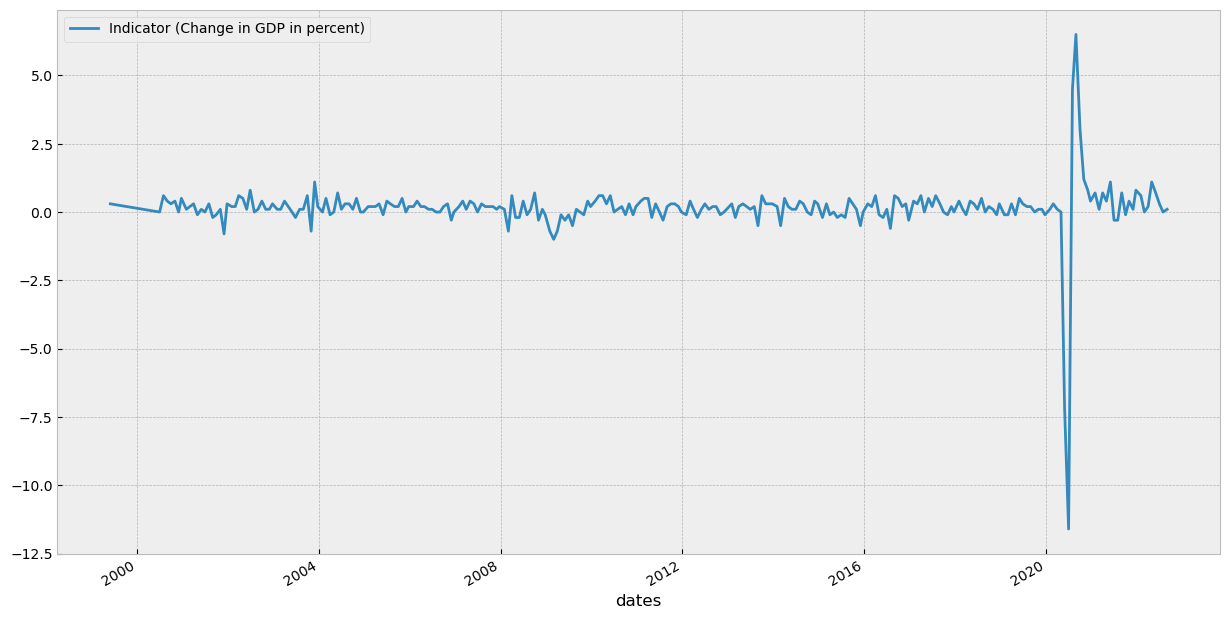

In [163]:
ca_indicator.plot(label='Indicator (Change in GDP in percent)')
plt.legend()

# Building a Trading Signal Using the Indicator

Using the indicator that we have created, we then try to create a trading signal.

We start by thinking how we can trade this strategy.

The most simplistic use of the indicator to trade would be using the indicator as the trading signal without any transformation. In our example, that would mean buy (go long) when the change in GDP is positive, and sell (go short) when the change in GDP is negative. This approach is shown in basic_signal() below.

We encourage you to try some new signals. As an example of how a signal might look like, you can look at the momentum trading signal in the Software Engineering project (Project 1).

In [164]:
def basic_signal(ts):
    # ts is a vector
    signal = pd.DataFrame(np.zeros((len(ts.index), 1)),index=ts.index, columns=['signal'])
    signal[ts > 0] = 1
    signal[ts < 0] = -1
    
    return signal

In [165]:
ca_sgnl = basic_signal(ca_gdp)
us_sgnl = basic_signal(us_gdp)

## Show Performance of the Trading Signal

### Choose the assets you want to trade

In [166]:
# In this case, we are postulating that when the change in GDP is positive,
# both the country's stock market and the country's currency will rise.
ca_assets = ['PT1 Index', 'CADUSD Curncy']
us_assets = ['ES1 Index', 'DXY Curncy']

### Calculate PnL

In [167]:
def calculate_pnl(ret, pos):
    # function to calculate profit and loss
    # we trade at the end of the period, and take profit & loss on the market move next period on our position
    # that's why we are shifting positon vector by one
    return ret.multiply(pos.shift(), axis=0).dropna()

In [168]:
# build the return series for each of the series
ca_returns = asset_prices[ca_assets].pct_change()
us_returns = asset_prices[us_assets].pct_change()

# Resample the Signal into daily signal
ca_daily_pos = ca_sgnl.resample('D').ffill()
us_daily_pos = us_sgnl.resample('D').ffill()

In [169]:
ca_sgnl.resample('D')

In [170]:
us_pnl = calculate_pnl(us_returns, us_daily_pos['signal'])
ca_pnl = calculate_pnl(ca_returns, us_daily_pos['signal'])

<AxesSubplot:title={'center':'Cumulative Trading Profit'}, xlabel='dates'>

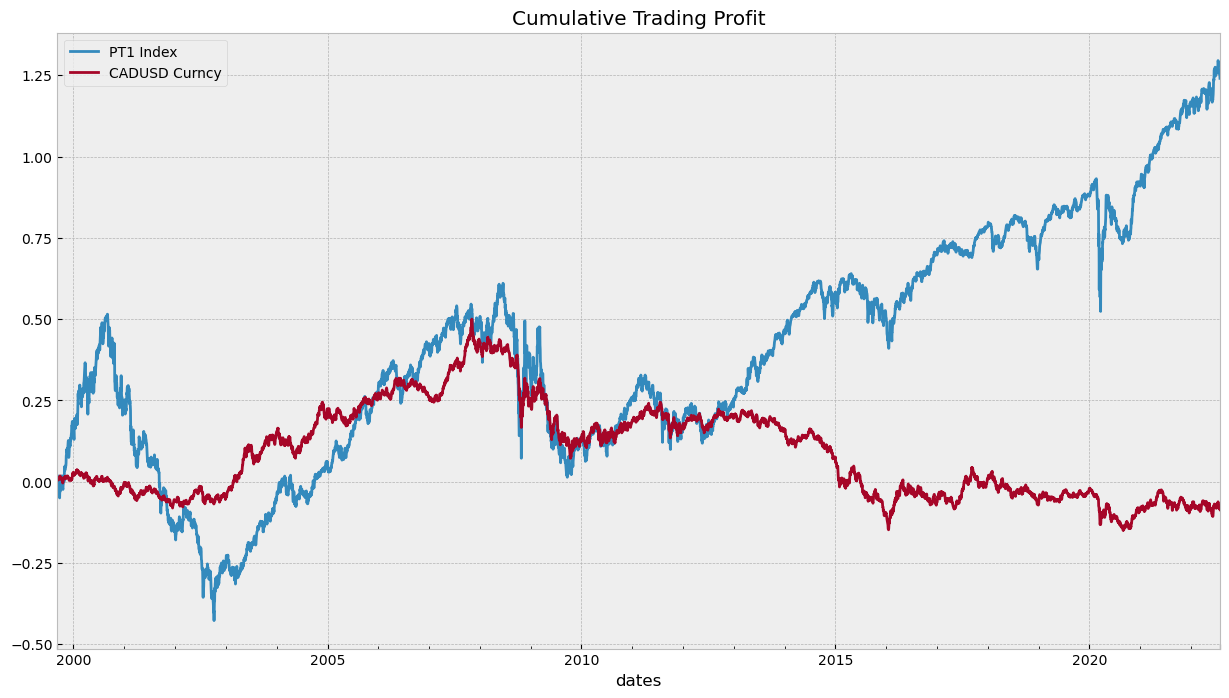

In [171]:
ca_pnl.cumsum().plot(title='Cumulative Trading Profit')

<AxesSubplot:title={'center':'Cumulative Trading Profit'}, xlabel='dates'>

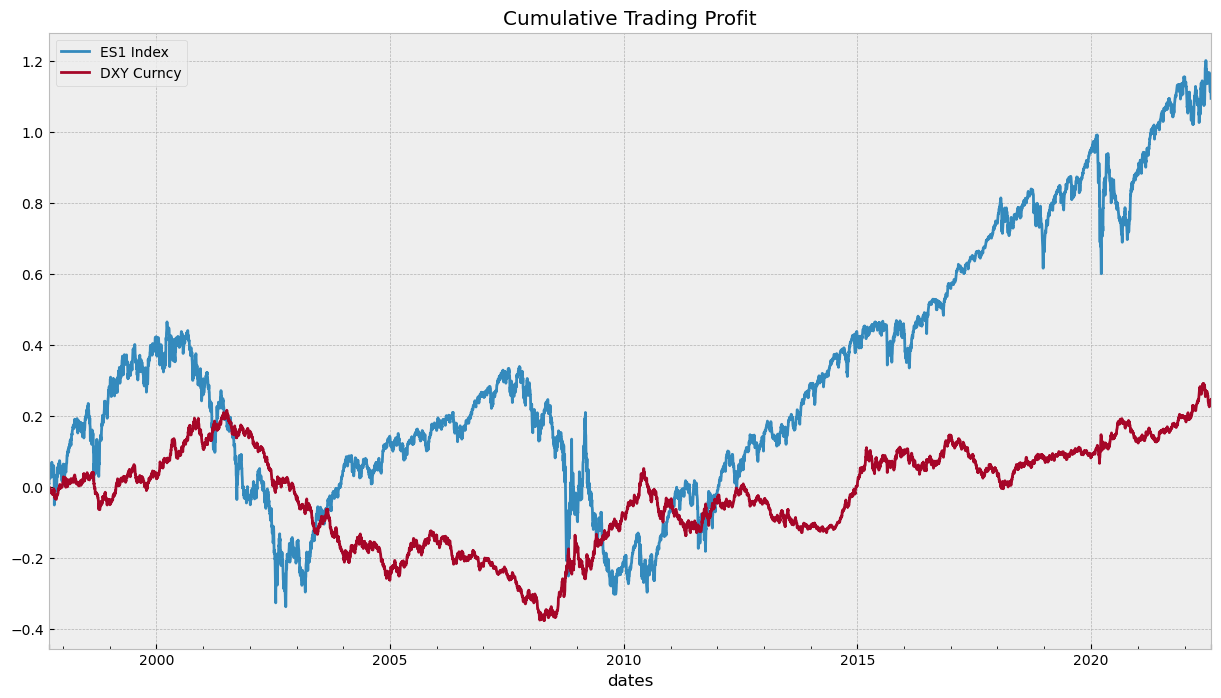

In [172]:
us_pnl.cumsum().plot(title='Cumulative Trading Profit')

## Some thoughts on the performance of the trading signal

Please examine the results of your trading signal and provide some commentary on the performance. 

If it performs well. Why? If it doesn't, why not? How can you make it better? 

What would be the next steps, if on the job, you are asked to further explore this investigation?

# 1. Economic Indicator

The economic data given provides growth data on {production, home sales, unemployment rate, and GDP}

GDP growth and unemployment are both lagging indicators, while production and home sales are leading indicators

I'm going to explore the pair of leading indicators {production, home sales} as leading indicators have prediction power which can come convenient to building a trading signal later.

In [173]:
ca_production = economic_data['CA']['IndustrialProduction']['actual_value']
us_production = economic_data['US']['IndustrialProduction']['actual_value']
ca_home_sales = economic_data['CA']['HomeSales']['actual_value']
us_home_sales = economic_data['US']['HomeSales']['actual_value']

Explore the data

In [174]:
ca_production

dates
1997-03-17    2.2
1997-04-16    0.6
1997-05-16    0.4
1997-06-27    0.5
1997-07-16   -0.2
             ... 
2022-04-14    4.2
2022-05-16    2.5
2022-06-14    1.7
2022-07-14   -2.0
2022-08-15   -0.8
Name: actual_value, Length: 306, dtype: float64

In [175]:
us_production

dates
1997-02-14    0.0
1997-03-14    0.5
1997-04-16    0.9
1997-05-15    0.0
1997-06-17    0.4
             ... 
2022-04-15    0.9
2022-05-17    1.1
2022-06-17    0.2
2022-07-15   -0.2
2022-08-16    0.6
Name: actual_value, Length: 307, dtype: float64

In [176]:
ca_home_sales

dates
2000-08-09    165.500
2000-09-11    146.000
2000-10-10    156.000
2000-11-08    164.800
2000-12-08    155.800
               ...   
2022-04-19    246.243
2022-05-16    267.330
2022-06-15    287.257
2022-07-18    273.841
2022-08-16    275.329
Name: actual_value, Length: 264, dtype: float64

In [177]:
us_home_sales

dates
2005-06-01    3.6
2005-07-06   -2.0
2005-08-01    0.6
2005-09-01   -1.0
2005-10-05    3.2
             ... 
2022-04-27   -1.2
2022-05-26   -3.9
2022-06-27    0.7
2022-07-27   -8.6
2022-08-24   -1.0
Name: actual_value, Length: 208, dtype: float64

In [178]:
# Seems like Canadian Home Sales is not a growth series
ca_home_sales_growth = ca_home_sales.pct_change().fillna(0) * 100
ca_home_sales_growth

dates
2000-08-09     0.000000
2000-09-11   -11.782477
2000-10-10     6.849315
2000-11-08     5.641026
2000-12-08    -5.461165
                ...    
2022-04-19    -0.409697
2022-05-16     8.563492
2022-06-15     7.454083
2022-07-18    -4.670382
2022-08-16     0.543381
Name: actual_value, Length: 264, dtype: float64

<AxesSubplot:title={'center':'US Home Sales'}, xlabel='dates'>

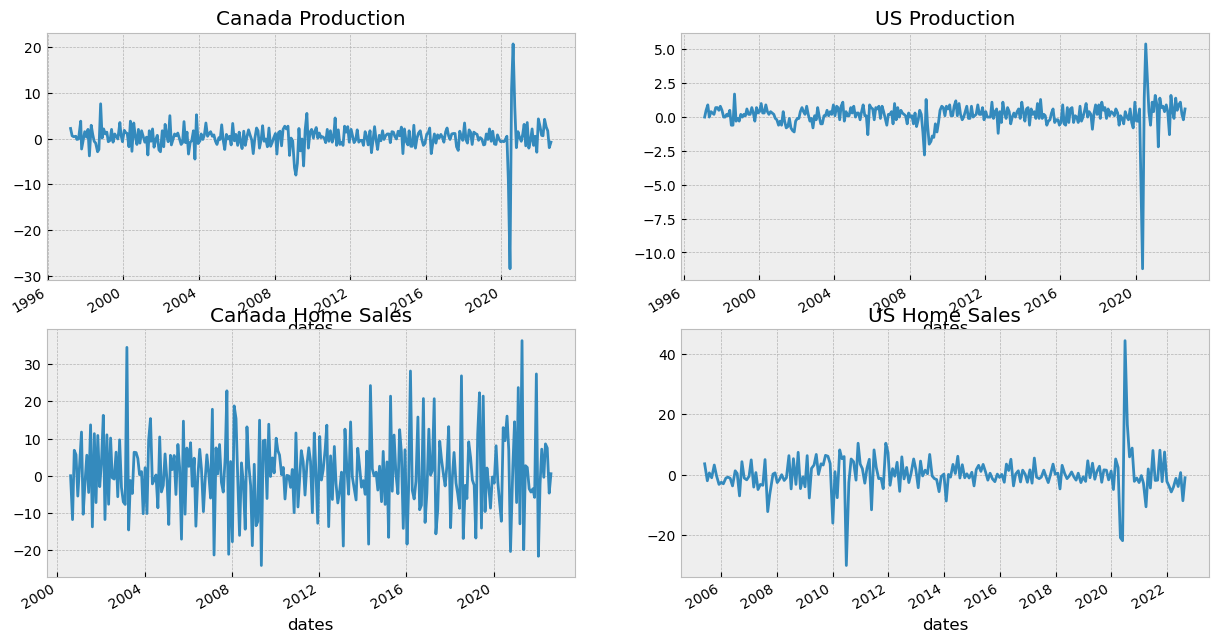

In [179]:
fig, axes = plt.subplots(nrows=2, ncols=2)

ca_production.plot(ax=axes[0,0], title='Canada Production')
us_production.plot(ax=axes[0,1], title='US Production')
ca_home_sales_growth.plot(ax=axes[1,0], title='Canada Home Sales')
us_home_sales.plot(ax=axes[1,1], title='US Home Sales')

## 1a. Production vs Home Sales

Production output are usually a good indicator of the strength of economy in the near future, as strong manufacturing increase the availability of goods and enables an increase of sales later; this directly boosts the GDP and is great for the economy; however, if not paired with strong purchase power, the increased availability of goods do not convert into sales, but rather inventory backlogs. 

The Home Sales data, though does not tell us directly about retail sales volume, should show the consumer confidence quite well. Confident consumers would be more willing to spend, providing the complementary info to production data.

I'm going to explore ways to combine these two.

First, seems like the dates are misaligned, I'll first align them, and since these are monthly data, I'll push them down to month end to avoid lookahead bias

In [180]:
ca_production.index = ca_production.index + pd.offsets.MonthEnd(0)
ca_home_sales_growth.index = ca_home_sales_growth.index + pd.offsets.MonthEnd(0)

Building my indicator dataframe which houses raw data needed

In [181]:
ca_production_homesales = ca_production.to_frame().join(ca_home_sales_growth.to_frame(), how='inner', lsuffix='Production', rsuffix='HomeSales')
indicator_ca = ca_production_homesales.rename({'actual_valueProduction': 'prod', 'actual_valueHomeSales': 'homesales'}, axis=1)
indicator_ca

prod  homesales
dates                      
2000-08-31   0.7   0.000000
2000-09-30  -1.3 -11.782477
2000-10-31   2.0   6.849315
2000-11-30  -1.0   5.641026
2000-12-31   1.7  -5.461165
...          ...        ...
2022-04-30   4.2  -0.409697
2022-05-31   2.5   8.563492
2022-06-30   1.7   7.454083
2022-07-31  -2.0  -4.670382
2022-08-31  -0.8   0.543381

[264 rows x 2 columns]

Now that the data processing is done, calculate my economic indicator

In [182]:
# Push both data to month end to avoid lookahead bias
window = 36 # 3 year rolling, to start, can tweak later
indicator_ca['prod_mean'] = indicator_ca['prod'].rolling(36).mean()
indicator_ca['prod_std'] = indicator_ca['prod'].rolling(36).std()

indicator_ca['hs_mean'] = indicator_ca['homesales'].rolling(36).mean()
indicator_ca['hs_std'] = indicator_ca['homesales'].rolling(36).std()

indicator_ca['prod_z'] = (indicator_ca['prod'] - indicator_ca['prod_mean']) / indicator_ca['prod_std']
indicator_ca['hs_z'] = (indicator_ca['homesales'] - indicator_ca['hs_mean']) / indicator_ca['hs_std']

indicator_ca['indicator'] = indicator_ca['prod_z'] + indicator_ca['hs_z']

Indicator: sum-of-rolling-z-score

<AxesSubplot:title={'center':'Sum of Zscores Economic Indicator'}, xlabel='dates'>

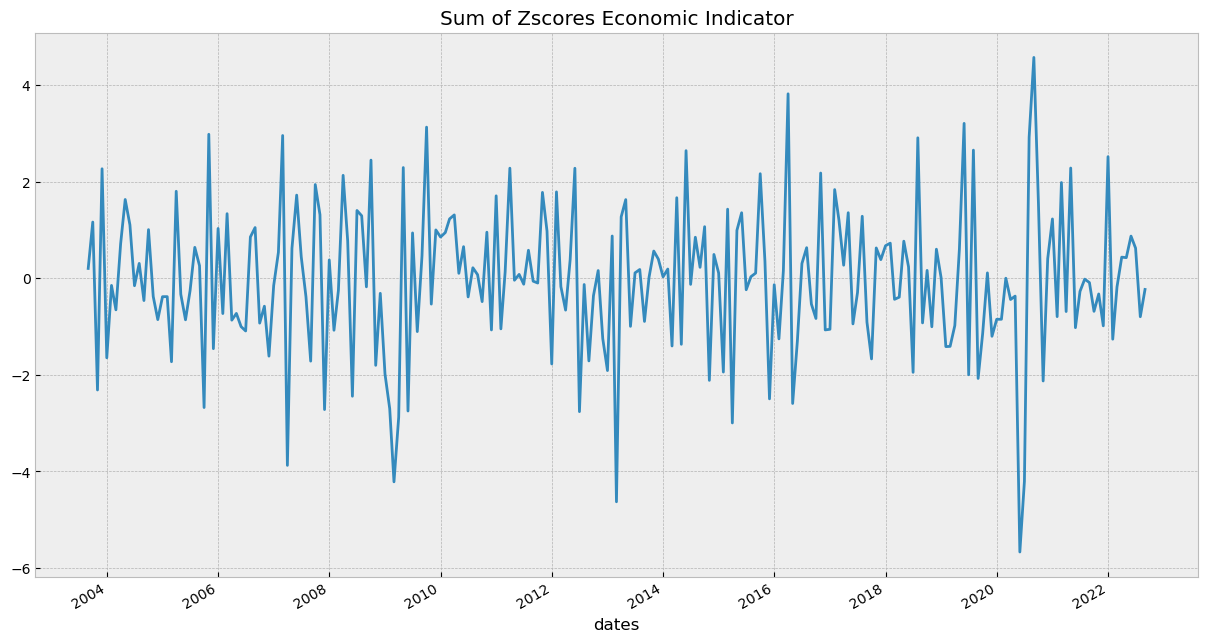

In [183]:
indicator_ca['indicator'].plot(title="Sum of Zscores Economic Indicator")

The indicator looks quite jittery, try some smoothing

<AxesSubplot:title={'center':'Smoothed Indicator'}, xlabel='dates'>

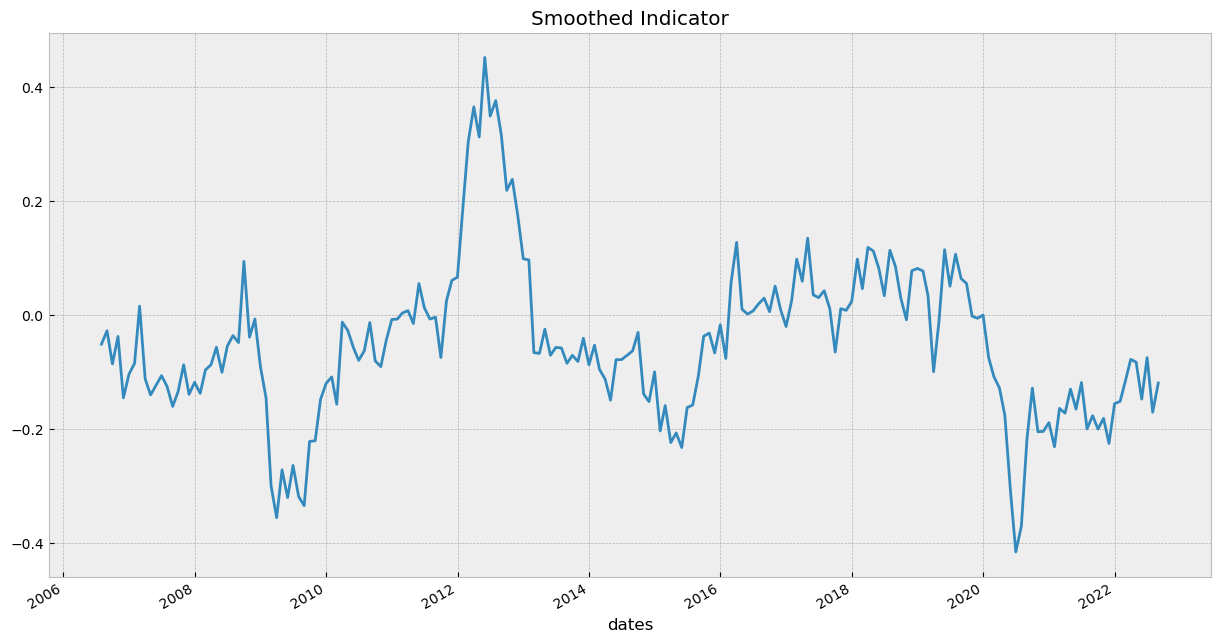

In [184]:
indicator_ca['indicator_smoothed'] = indicator_ca['indicator'].rolling(window).mean()
indicator_ca['indicator_smoothed'].plot(title='Smoothed Indicator')

Testing out if it has good prediction power on GDP growth

In [185]:
ca_ind_smoothed = indicator_ca['indicator_smoothed'].dropna()
ca_ind = indicator_ca['indicator'].dropna() # Smoothing makes it less effective an indicator
ca_gdp.index = ca_gdp.index + pd.offsets.MonthEnd(0)
ca_gdp = ca_gdp[~ca_gdp.index.duplicated(keep='first')] # not ideal here since some dates are month end and some dates are month beginning, remove such cases and flatfill
ca_gdp = ca_gdp.resample('M').ffill()

In [186]:
ca_gdp = ca_gdp.reindex(ca_ind.index)

In [187]:
def lagged_corr(x, y, xlag=0, ylag=0):
    return x.shift(xlag).corr(y.shift(ylag))


In [188]:
# Assuming my indicator is still leading, try different lagging correlation
lags = [0, 1, 2, 3, 4, 5]
ca_res = pd.DataFrame({'non smoothed': [lagged_corr(ca_ind, ca_gdp, lag) for lag in lags], 
                    'smoothed': [lagged_corr(ca_ind_smoothed, ca_gdp, lag) for lag in lags]}, index=lags)
ca_res

non smoothed  smoothed
0      0.424592  0.118335
1      0.238520 -0.015883
2     -0.038907 -0.093381
3     -0.072984 -0.094692
4     -0.026162 -0.083316
5      0.036382 -0.093724

Seems like smoothing has ruined it. (or maybe a different smoothing technique/param should be used) But with non-smoothing, the indicator seems to have moderate correlation with GDP growth.

<AxesSubplot:title={'center':'My Indicator vs. the GDP growth'}, xlabel='dates'>

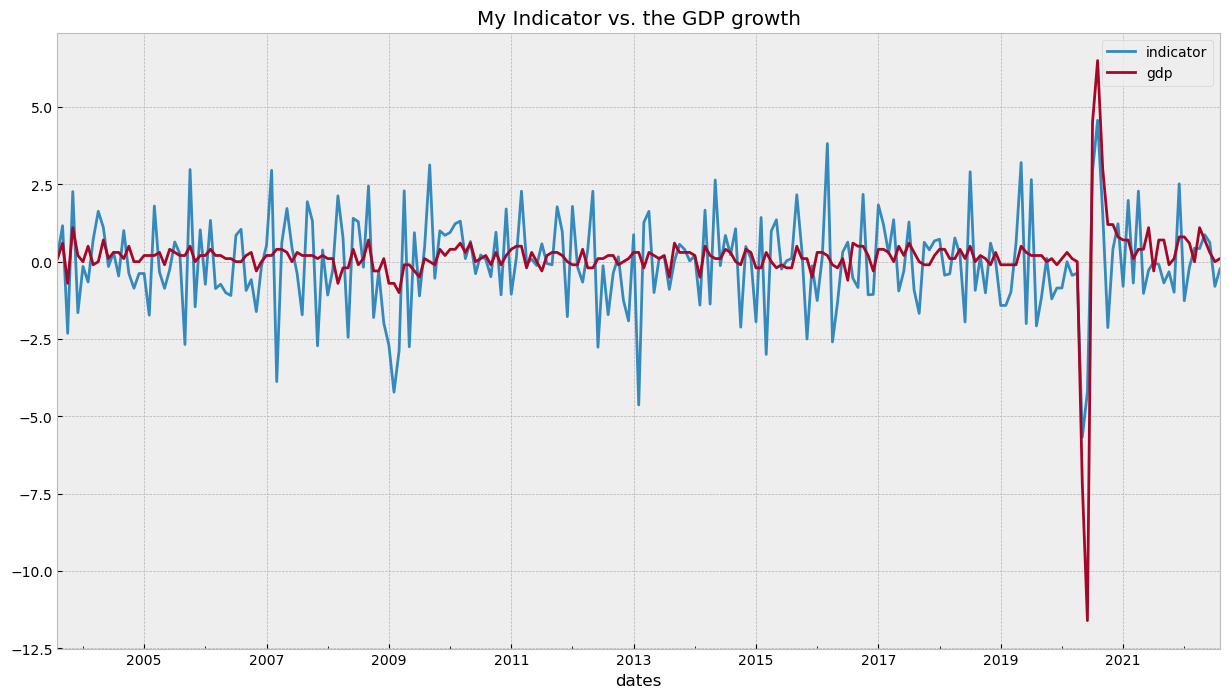

In [189]:
a = pd.DataFrame({'indicator': ca_ind, 'gdp': ca_gdp}, index=ca_gdp.index)
a.plot(title="My Indicator vs. the GDP growth")

## 1b. Create the same indicator for the US

The US data are in different granularity. Need to process as such

In [190]:
us_production.index = us_production.index + pd.offsets.MonthEnd(0)
us_home_sales.index = us_home_sales.index + pd.offsets.MonthEnd(0)

In [191]:
us_home_sales

dates
2005-06-30    3.6
2005-07-31   -2.0
2005-08-31    0.6
2005-09-30   -1.0
2005-10-31    3.2
             ... 
2022-04-30   -1.2
2022-05-31   -3.9
2022-06-30    0.7
2022-07-31   -8.6
2022-08-31   -1.0
Name: actual_value, Length: 208, dtype: float64

In [192]:
us_production_homesales = us_production.to_frame().join(us_home_sales.to_frame(), how='inner', lsuffix='Production', rsuffix='HomeSales')
us_indicator = us_production_homesales.rename({'actual_valueProduction': 'prod', 'actual_valueHomeSales': 'homesales'}, axis=1)
us_indicator = us_indicator[~us_indicator.index.duplicated(keep='first')]

In [193]:
window = 36 # 3 year rolling, to start, can tweak later
us_indicator['prod_mean'] = us_indicator['prod'].rolling(36).mean()
us_indicator['prod_std'] = us_indicator['prod'].rolling(36).std()

us_indicator['hs_mean'] = us_indicator['homesales'].rolling(36).mean()
us_indicator['hs_std'] = us_indicator['homesales'].rolling(36).std()

us_indicator['prod_z'] = (us_indicator['prod'] - us_indicator['prod_mean']) / us_indicator['prod_std']
us_indicator['hs_z'] = (us_indicator['homesales'] - us_indicator['hs_mean']) / us_indicator['hs_std']

us_indicator['indicator'] = us_indicator['prod_z'] + us_indicator['hs_z']

In [194]:
us_ind = us_indicator['indicator'].dropna() # Smoothing makes it less effective an indicator
us_gdp.index = us_gdp.index + pd.offsets.MonthEnd(0)
us_gdp = us_gdp[~us_gdp.index.duplicated(keep='first')] # not ideal here since some dates are month end and some dates are month beginning, remove such cases and flatfill
us_gdp = us_gdp.resample('M').ffill() # US GDP data is quarterly only, so there might be some difference.

In [195]:
us_gdp = us_gdp.reindex(us_ind.index)

In [196]:
us_res = pd.DataFrame({'lagged correlation': [lagged_corr(us_ind, us_gdp, lag) for lag in lags]}, index=lags)
us_res

lagged correlation
0           -0.055177
1           -0.095794
2            0.090642
3            0.395880
4            0.537728
5            0.202283

Interesting observation: The max correlation occurs at lag=4 for the US - does the US production and home sales data lead the economy more than their Canadian counter parts?

In [197]:
original_gdp_us = economic_data['US']['GDP'][['actual_value']]
original_gdp_us.index = original_gdp_us.index + pd.offsets.MonthEnd(0)
compare = us_gdp.to_frame().join(original_gdp_us, how='outer', lsuffix='_monthly', rsuffix='_quarterly')
compare.iloc[-30:]

actual_value_monthly  actual_value_quarterly
dates                                                   
2020-03-31                   2.1                     NaN
2020-04-30                  -4.8                    -4.8
2020-05-31                  -4.8                     NaN
2020-06-30                  -4.8                     NaN
2020-07-31                 -32.9                   -32.9
2020-08-31                 -32.9                     NaN
2020-09-30                 -32.9                     NaN
2020-10-31                  33.1                    33.1
2020-11-30                  33.1                     NaN
2020-12-31                  33.1                     NaN
2021-01-31                   4.0                     4.0
2021-02-28                   4.0                     NaN
2021-03-31                   4.0                     NaN
2021-04-30                   6.4                     6.4
2021-05-31                   6.4                     NaN
2021-06-30                   6.4                     NaN
2021-07-31                   6.5                     6.5
2021-08-31                   6.5                     NaN
2021-09-30                   6.5                     NaN
2021-10-31                   2.0                     2.0
2021-11-30                   2.0                     NaN
2021-12-31                   2.0                     NaN
2022-01-31                   6.9                     6.9
2022-02-28                   6.9                     NaN
2022-03-31                   6.9                     NaN
2022-04-30                  -1.4                    -1.4
2022-05-31                  -1.4                     NaN
2022-06-30                  -1.4                     NaN
2022-07-31                  -0.9                    -0.9
2022-08-31                   NaN                     NaN

The `ffill()` function effectively expands into the future, what if we `ffill()` backwards?

In [198]:
# fill backwards in time, instead of the default forward in time
us_gdp_alt = original_gdp_us.reindex(us_gdp.index, axis=0).fillna(0)
us_gdp_alt = pd.DataFrame(us_gdp_alt.to_numpy() + us_gdp_alt.shift(-1).to_numpy() + us_gdp_alt.shift(-2).to_numpy(), index=us_gdp.index)

In [199]:
us_alt_res = pd.DataFrame({'lagged correlation': [lagged_corr(us_ind, us_gdp_alt[0], lag) for lag in lags]}, index=lags)
us_alt_res

lagged correlation
0            0.089788
1            0.394576
2            0.535889
3            0.202156
4           -0.155966
5           -0.217712

By comparing different ways to resample and fill, we can see that some of the offset in peak lag correlation between Canada and the US is reduced by backward filling approach

However, even with the backward fill, the peak correlation is still at lag=2months, not to mention the default forward fill approach is more economically intuitive. There remains some leading effect between the US indicator and the US GDP 

<AxesSubplot:title={'center':'US Indicator vs. the US GDP growth'}, xlabel='dates'>

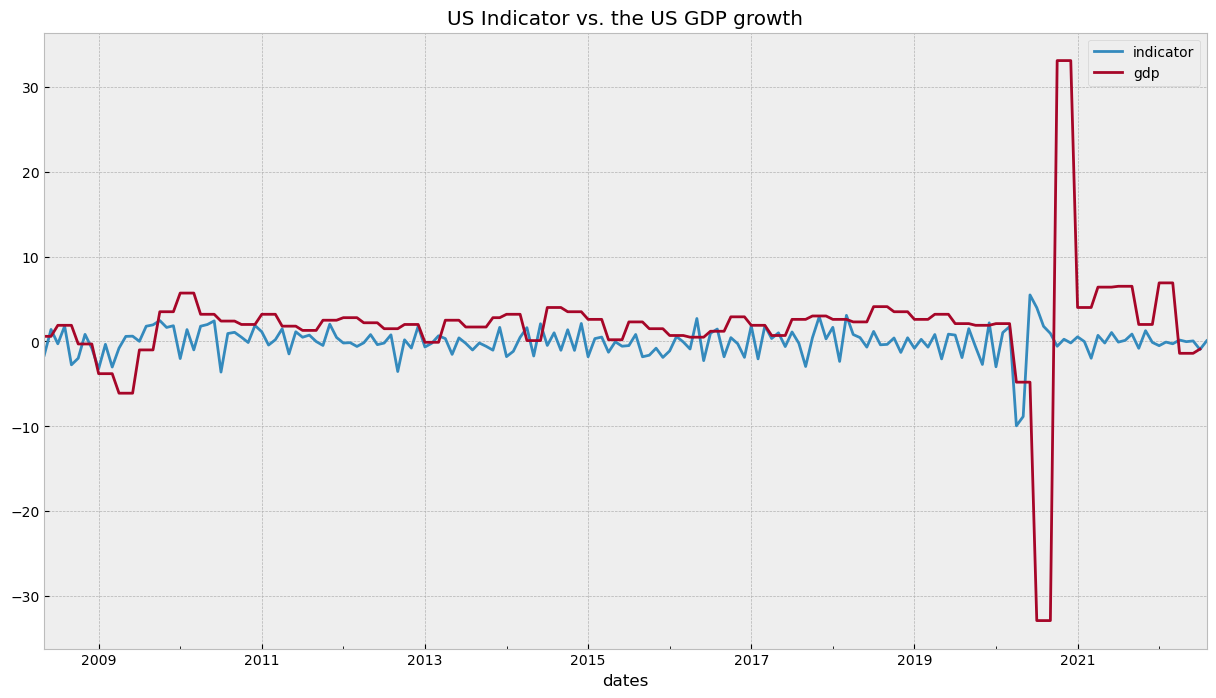

In [200]:
b = pd.DataFrame({'indicator': us_ind, 'gdp': us_gdp}, index=us_gdp.index)
b.plot(title="US Indicator vs. the US GDP growth")

## 2. Trading Signal

Creating a trading signal with the economic indicator, I'm going to try three signals:

- Timeseries signal for Canada and the US
- Cross sectional signal for FX trading

### 2.a Timeseries signal for Canada

since the indicator is a z-score based, demeaned indicator, I'm going to use its binary pos/neg series as a buy/sell signal: When indicator is up - it signals the economy will expand and suppor the growth of stock market

In [201]:
signal_ca = ca_ind.apply(lambda x: 1 if x > 0 else -1)

In [202]:
position_ca = signal_ca.cumsum().shift()

<AxesSubplot:title={'center':'cumulative pnl CA'}, xlabel='dates'>

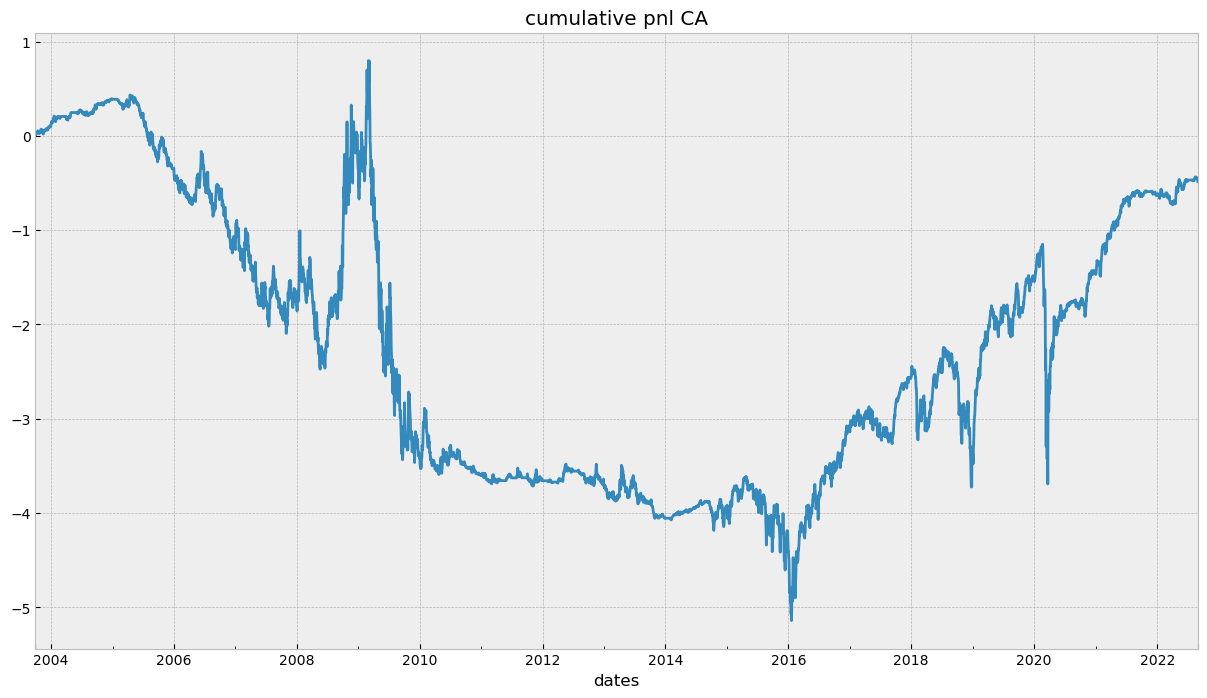

In [203]:
pt1_ret = ca_returns['PT1 Index']
daily_pos_ca = position_ca.resample('D').ffill()
pnl = calculate_pnl(pt1_ret, daily_pos_ca)
pnl.cumsum().plot(title="cumulative pnl CA")

### 2b. Timeseries Signal for the US

In [204]:
signal_us = us_ind.apply(lambda x: 1 if x > 0 else -1)
position_us = signal_us.cumsum().shift()

<AxesSubplot:title={'center':'cumulative pnl US'}, xlabel='dates'>

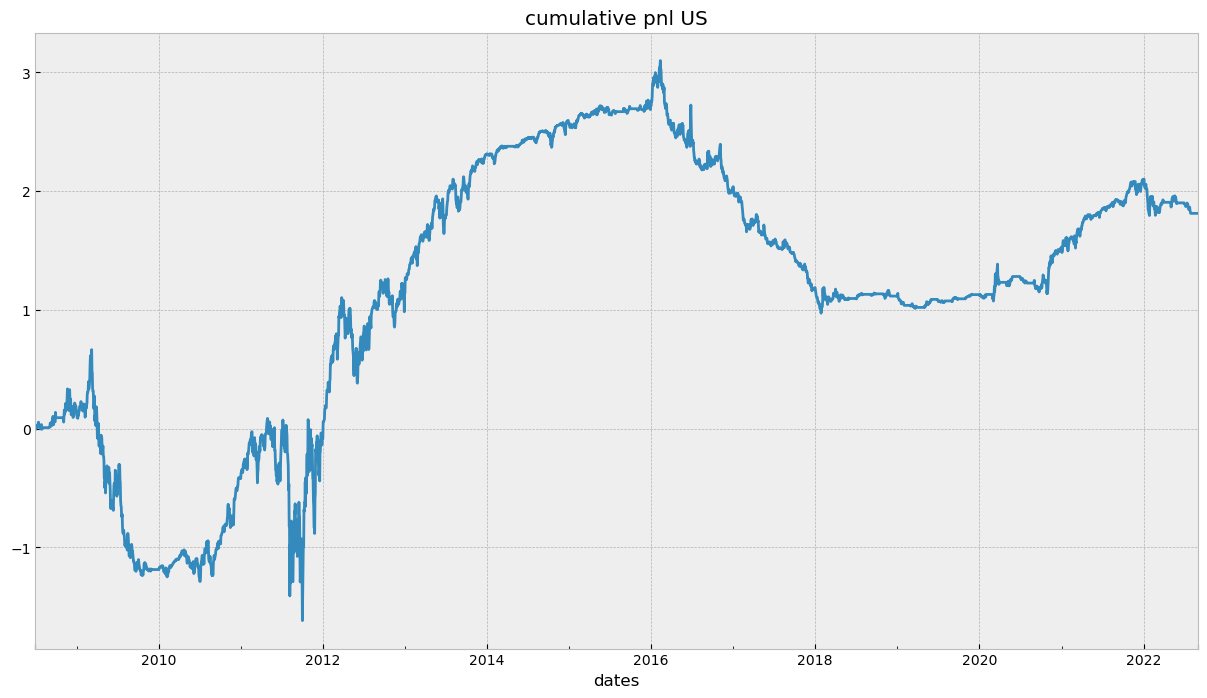

In [205]:
es1_ret = us_returns['ES1 Index']
daily_pos_us = position_us.resample('D').ffill()
us_pnl = calculate_pnl(es1_ret, daily_pos_us)
us_pnl.cumsum().plot(title="cumulative pnl US")

US indicator performance is better than Canada indicator, which could be driven by:

1. The stronger leading effect of US indicator compared to its CA counterpart makes it build the appropriate portfolio earlier before the pricing in happens in the market

2. US market affording more risk premia than the Canadian market

### 2c. Cross Section FX signal

Given we have two economic indicators, one for each country, we can create a differential signal for fx trading
The signal will be cross-sectional as when the differential tilts towards Canada, the signal will go long CADUSD and short dollar index, and vice versa

In [216]:
diff_ca_us = ca_ind - us_ind
diff_ca_us = signal_ca_us.dropna()

In [220]:
signal_ca_us = diff_ca_us.apply(lambda x: -1 if x < 0 else 1)
pos_cadusd = signal_us.cumsum().shift().resample("D").ffill()
pos_usdidx = (-1 * signal_us).cumsum().shift().resample("D").ffill()
cadusd_returns = ca_returns['CADUSD Curncy']
usdidx_returns = us_returns['DXY Curncy']

cadusd_pnl = calculate_pnl(cadusd_returns, pos_cadusd)
usdidx_pnl = calculate_pnl(usdidx_returns, pos_usdidx)

In [222]:
cadusd_pnl.cumsum().plot()
usdidx_pnl.cumsum().plot()

<AxesSubplot:xlabel='dates'>

In [224]:
pos_usdidx.plot()

<AxesSubplot:xlabel='dates'>

Neither of the asset performed well - One external driver of currency, that isn't captured through GDP growth, is the monetary policy, which also has a significant effect on currency movements. 

Also, the USD index only depends a little on the CAD/USD fx